# PRE_PROCESSING

---



In [ ]:
import copy
import numpy as np
import os
import scipy.io as sio
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [ ]:
!wget http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat

URL transformed to HTTPS due to an HSTS policy
--2022-11-21 19:55:46--  https://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5953527 (5.7M)
Saving to: ‘Indian_pines_corrected.mat.4’

Indian_pines_correc 100%[===================>]   5.68M  1.57MB/s    in 3.6s    

2022-11-21 19:55:51 (1.57 MB/s) - ‘Indian_pines_corrected.mat.4’ saved [5953527/5953527]

URL transformed to HTTPS due to an HSTS policy
--2022-11-21 19:55:51--  https://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1125 (1.1K)
Saving to: ‘Indian_pines_gt.mat.4’

Indian_pines_gt.mat 100%[===================>]   1.10K  --.-KB/s    in 0s      

2022-11-21 19:55:52 (72.0 MB/s) - ‘Indian_

In [ ]:
def random_unison(a,b, rstate=None):
    assert len(a) == len(b)
    p = np.random.RandomState(seed=rstate).permutation(len(a))
    return a[p], b[p]

In [ ]:
def random_single(a, rstate=None):
    return a[np.random.RandomState(seed=rstate).permutation(len(a))]

In [ ]:
def loadData(num_components):
    data_path = os.path.join(os.getcwd())
    data = sio.loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
    labels = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']
    num_class = 16
    shapeor = data.shape
    data = data.reshape(-1, data.shape[-1])
    if num_components != None:
        data = PCA(n_components=num_components).fit_transform(data)
        shapeor = np.array(shapeor)
        shapeor[-1] = num_components
    data = StandardScaler().fit_transform(data)
    data = data.reshape(shapeor)
    return data, labels, num_class

In [ ]:
def split_data(pixels, labels, value, splitdset="sklearn", rand_state=None):
    if splitdset == "sklearn":
        X_test, X_train, y_test, y_train = \
            train_test_split(pixels, labels, test_size=value, stratify=labels, random_state=rand_state)
    elif "custom" in splitdset:
        labels = labels.reshape(-1)
        X_train = []; X_test = []; y_train = []; y_test = [];
        if "custom" == splitdset: 
            values = np.unique(value, return_counts=1)[1][1:]
            for idi, i in enumerate(values):
                samples = pixels[labels==idi+1]
                samples = random_single(samples, rstate=rand_state)
                for a in samples[:i]: 
                    X_train.append(a); y_train.append(idi)
                for a in samples[i:]:
                    X_test.append(a); y_test.append(idi)
        elif "custom2" == splitdset:
            for idi, i in enumerate(value):
                samples = pixels[labels==idi]
                samples = random_single(samples, rstate=rand_state)
                for a in samples[:i]: 
                    X_train.append(a); y_train.append(idi)
                for a in samples[i:]:
                    X_test.append(a); y_test.append(idi)
        X_train = np.array(X_train); X_test = np.array(X_test)
        y_train = np.array(y_train); y_test = np.array(y_test)
        X_train, y_train = random_unison(X_train,y_train, rstate=rand_state)
    return X_train, X_test, y_train, y_test

In [ ]:
def select_samples(pixels, labels, samples):
    return split_data(pixels, labels, samples, splitdset="custom")

In [ ]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [ ]:
def createImageCubes(X, y, windowSize, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels.astype("int")


In [ ]:
import numpy as np
from sklearn import metrics 
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
from operator import truediv

In [ ]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc



# TRAIN

---



In [ ]:
import argparse
import cv2
import gc
import keras.backend as K
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.losses import categorical_crossentropy
from keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, GlobalAveragePooling2D
from keras.applications import vgg16
from tensorflow.keras.applications import ResNet50
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras import regularizers
from keras.utils import to_categorical as keras_to_categorical
import numpy as np
import sys

In [ ]:
components=3
spatialsize=63
repeat=1
random_state=None
tr_percent=0.03
val_percent=0.1
use_val='store_true'
batch_size=100
verbosetrain='store_true'
lrate=1e-4

In [ ]:
pixels, labels, num_class = \
loadData(components)
pixels, labels = createImageCubes(pixels, labels, spatialsize, removeZeroLabels = False)
pixels = np.array([cv2.resize(a, (a.shape[0]+1,a.shape[1]+1), interpolation=cv2.INTER_CUBIC)  for a in pixels])

stats = np.ones((repeat, num_class+3)) * -1000.0 # OA, AA, K, Aclass


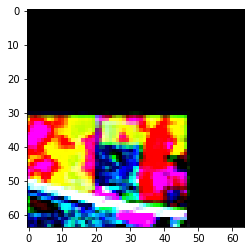

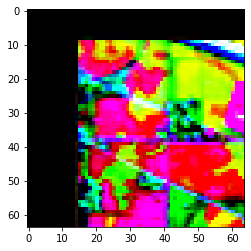

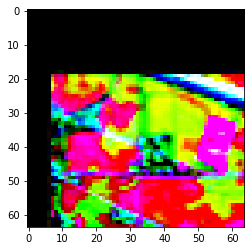

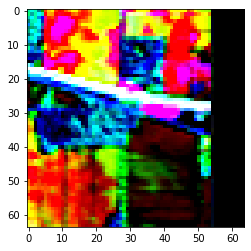

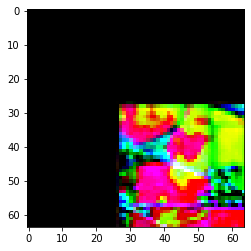

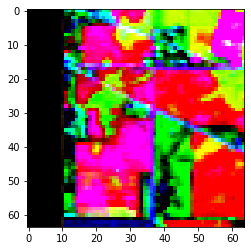

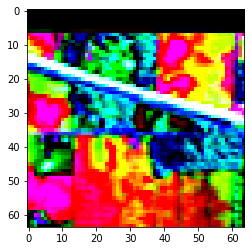

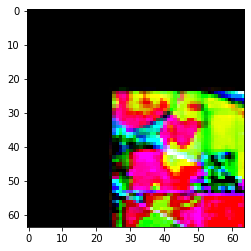

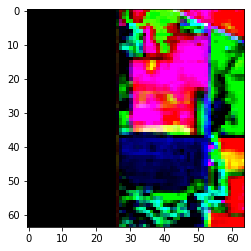

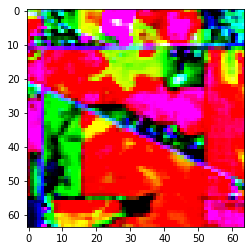

In [ ]:
from matplotlib import pyplot as plt
import random
for i in range(10):
  plt.imshow(pixels[random.randint(1,10248)], interpolation='none')
  plt.show()

In [ ]:
rstate = random_state+pos if random_state != None else None
for pos in range(repeat):
        rstate = random_state+pos if random_state != None else None
        pixels = pixels[labels!=0]
        labels = labels[labels!=0] - 1
        x_train, x_test, y_train, y_test = split_data(pixels, labels, tr_percent, rand_state=rstate)

        if use_val:
            x_val, x_test, y_val, y_test = \
                split_data(x_test, y_test, val_percent, rand_state=rstate)

# VGG 16 

---

In [ ]:
base_model= vgg16.VGG16(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(np.unique(labels)), activation='softmax', name='predictions')(x)
model_vgg = Model(base_model.input, predictions)

valdata = (x_val, keras_to_categorical(y_val, num_class)) if use_val else (x_test, keras_to_categorical(y_test, num_class))

In [ ]:
model_vgg.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0   

In [ ]:
model_vgg.compile(loss=categorical_crossentropy, optimizer=Adam(lr=lrate), metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history=model_vgg.fit(x_train, keras_to_categorical(y_train, num_class),
                        batch_size=batch_size,
                        epochs=60,
                        verbose=verbosetrain,
                        validation_data=valdata,
                        callbacks = [ModelCheckpoint("best_model.h5", monitor='val_loss', verbose=0, save_best_only=True)])

Epoch 1/60
Epoch 2/60
Epoch 3/60
Epoch 4/60
Epoch 5/60
Epoch 6/60
Epoch 7/60
Epoch 8/60
Epoch 9/60
Epoch 10/60
Epoch 11/60
Epoch 12/60
Epoch 13/60
Epoch 14/60
Epoch 15/60
Epoch 16/60
Epoch 17/60
Epoch 18/60
Epoch 19/60
Epoch 20/60
Epoch 21/60
Epoch 22/60
Epoch 23/60
Epoch 24/60
Epoch 25/60
Epoch 26/60
Epoch 27/60
Epoch 28/60
Epoch 29/60
Epoch 30/60
Epoch 31/60
Epoch 32/60
Epoch 33/60
Epoch 34/60
Epoch 35/60
Epoch 36/60
Epoch 37/60
Epoch 38/60
Epoch 39/60
Epoch 40/60
Epoch 41/60
Epoch 42/60
Epoch 43/60
Epoch 44/60
Epoch 45/60
Epoch 46/60
Epoch 47/60
Epoch 48/60
Epoch 49/60
Epoch 50/60
Epoch 51/60
Epoch 52/60
Epoch 53/60
Epoch 54/60
Epoch 55/60
Epoch 56/60
Epoch 57/60
Epoch 58/60
Epoch 59/60
Epoch 60/60


In [ ]:
print(history.history['accuracy'])

[0.09415584057569504, 0.30844154953956604, 0.4545454680919647, 0.5389610528945923, 0.600649356842041, 0.6850649118423462, 0.7175324559211731, 0.7889610528945923, 0.8051947951316833, 0.801948070526123, 0.7889610528945923, 0.8668830990791321, 0.850649356842041, 0.8571428656578064, 0.9025974273681641, 0.8961039185523987, 0.9025974273681641, 0.9188311696052551, 0.9383116960525513, 0.9448052048683167, 0.9545454382896423, 0.9642857313156128, 0.9285714030265808, 0.9740259647369385, 0.9642857313156128, 0.9610389471054077, 0.9253246784210205, 0.9155844449996948, 0.9253246784210205, 0.9090909361839294, 0.9318181872367859, 0.9220778942108154, 0.9188311696052551, 0.948051929473877, 0.951298713684082, 0.9610389471054077, 0.9642857313156128, 0.9707792401313782, 0.9383116960525513, 0.9318181872367859, 0.948051929473877, 0.9707792401313782, 0.9870129823684692, 0.9837662577629089, 0.9707792401313782, 0.9772727489471436, 0.9935064911842346, 0.9870129823684692, 0.9805194735527039, 0.9870129823684692, 0.9

In [ ]:
print(history.history['val_accuracy'])

[0.35979899764060974, 0.45125627517700195, 0.5226130485534668, 0.6492462158203125, 0.6804019808769226, 0.729648232460022, 0.7788944840431213, 0.7899497747421265, 0.795979917049408, 0.7869346737861633, 0.808040201663971, 0.8251256346702576, 0.8351758718490601, 0.8231155872344971, 0.8512563109397888, 0.8442211151123047, 0.8371859192848206, 0.8683416843414307, 0.8673366904258728, 0.8532663583755493, 0.8864321708679199, 0.8562813997268677, 0.8894472122192383, 0.897487461566925, 0.9045225977897644, 0.8954774141311646, 0.8874371647834778, 0.8814070224761963, 0.8763819336891174, 0.8743718862533569, 0.8753768801689148, 0.8371859192848206, 0.897487461566925, 0.897487461566925, 0.8773869276046753, 0.8964824080467224, 0.8984924554824829, 0.8964824080467224, 0.8753768801689148, 0.9065326452255249, 0.9075376987457275, 0.8964824080467224, 0.9195979833602905, 0.913567841053009, 0.8964824080467224, 0.8984924554824829, 0.9005025029182434, 0.8954774141311646, 0.905527651309967, 0.9286432266235352, 0.928

In [ ]:
print(history.history['loss'])

[2.7721176147460938, 2.2881100177764893, 1.7898086309432983, 1.3743565082550049, 1.1024178266525269, 0.9565199017524719, 0.865699291229248, 0.7247062921524048, 0.5484360456466675, 0.6109925508499146, 0.5952848792076111, 0.4750419855117798, 0.4648135304450989, 0.4377792179584503, 0.3196953237056732, 0.3186083436012268, 0.3103930354118347, 0.24400277435779572, 0.1984332948923111, 0.19019244611263275, 0.1617426574230194, 0.15446223318576813, 0.19115221500396729, 0.1082620769739151, 0.11783315241336823, 0.11767542362213135, 0.17948399484157562, 0.26003095507621765, 0.22836345434188843, 0.2807857394218445, 0.2055039405822754, 0.2250577062368393, 0.269922137260437, 0.20376282930374146, 0.1814066469669342, 0.12524066865444183, 0.10983608663082123, 0.0981643870472908, 0.44401469826698303, 0.18402288854122162, 0.15227749943733215, 0.10029024630784988, 0.08399545401334763, 0.06528683751821518, 0.10794230550527573, 0.0516059435904026, 0.03725369647145271, 0.045830439776182175, 0.07716064900159836

In [ ]:
print(history.history['val_loss'])

[2.2979633808135986, 1.730428695678711, 1.3476159572601318, 1.1091078519821167, 0.9260832071304321, 0.8291221261024475, 0.727547287940979, 0.7764891386032104, 0.6407305598258972, 0.6106814742088318, 0.5733041763305664, 0.5708246827125549, 0.512387752532959, 0.4612698256969452, 0.4427444636821747, 0.44455331563949585, 0.4965939521789551, 0.39721155166625977, 0.4941166937351227, 0.5395001769065857, 0.47395893931388855, 0.4884313642978668, 0.3379790782928467, 0.3228043019771576, 0.3932521641254425, 0.4044172167778015, 0.36722174286842346, 0.47707295417785645, 0.44323763251304626, 0.40786173939704895, 0.4195956587791443, 0.7404748201370239, 0.3661609888076782, 0.40507492423057556, 0.669243335723877, 0.4610399305820465, 0.33853989839553833, 0.40728625655174255, 0.4359453618526459, 0.4023112952709198, 0.32972481846809387, 0.41199421882629395, 0.315481573343277, 0.3776046335697174, 0.3959777057170868, 0.4634721279144287, 0.4968176782131195, 0.5924561619758606, 0.43859443068504333, 0.315376132

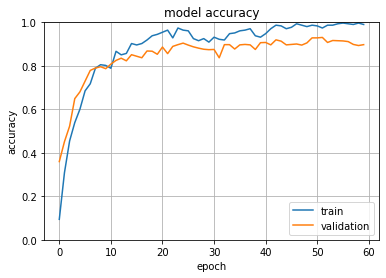

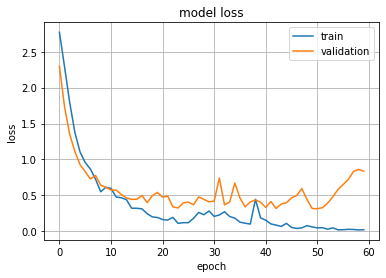

In [ ]:
# summarize history for accuracy
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim(0, 1)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid(True)
plt.legend(['train', 'validation'], loc='best') 
plt.savefig("model_accuracy_100.png")
plt.show()

# summarize history for loss 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid(True)
plt.legend(['train', 'validation'], loc='upper right') 
plt.savefig("model_loss_100.png")
plt.show()

In [ ]:
model_vgg.save('best_model.h5')

# TEST

---



In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
from operator import truediv
import itertools

In [ ]:
def Accuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [ ]:
import seaborn as sns
def reports(y_pred, y_test):
   target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
           ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
            'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
           'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
           'Stone-Steel-Towers']
   classification = classification_report(y_test, y_pred)
   oa = accuracy_score(y_test, y_pred)
   confusion = confusion_matrix(y_test, y_pred)
   plt.figure(figsize = (16,16))
   sns.heatmap(confusion,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = target_names , yticklabels = target_names)
   each_acc, aa = Accuracy(confusion)
   kappa = cohen_kappa_score(y_test, y_pred)
   print( "classification result: \n")
   print(classification)
   
   return classification, confusion, np.array([oa, aa, kappa] + list(each_acc)) * 100


PARAMETERS 14850128
280/280 [==============================] - 5s 17ms/step
classification result: 

              precision    recall  f1-score   support

           0       1.00      0.37      0.54        41
           1       0.95      0.86      0.91      1246
           2       0.89      0.94      0.92       724
           3       0.95      0.95      0.95       207
           4       0.99      0.78      0.87       422
           5       0.96      0.97      0.96       637
           6       0.42      1.00      0.59        24
           7       0.99      1.00      1.00       418
           8       0.50      0.18      0.26        17
           9       0.84      0.96      0.89       849
          10       0.96      0.87      0.91      2143
          11       0.89      0.95      0.92       517
          12       0.93      0.91      0.92       179
          13       1.00      0.97      0.98      1104
          14       0.58      0.99      0.73       337
          15       0.84      0.86 

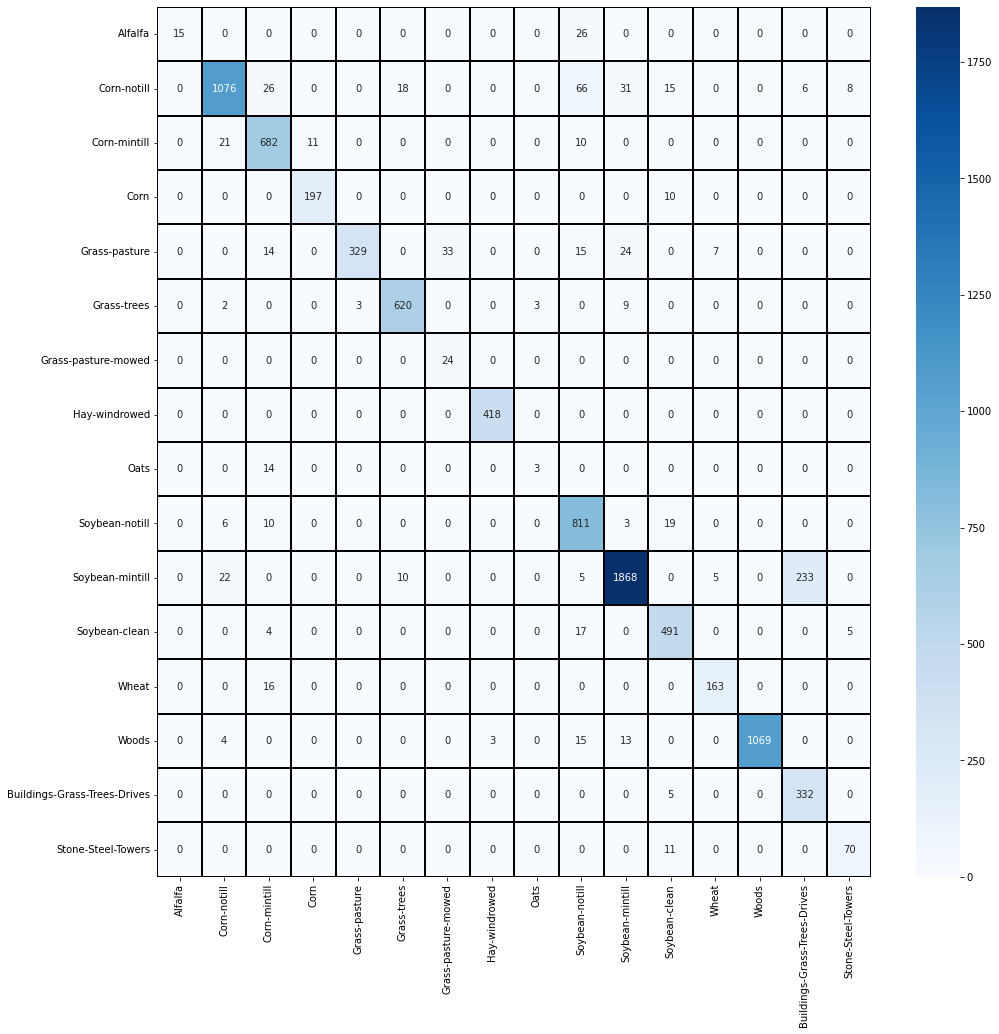

In [ ]:
print("PARAMETERS", model_vgg.count_params())
stats[pos,:] = reports(np.argmax(model_vgg.predict(x_test), axis=1), y_test)[2]
print(list(stats[-1]))

# RESNET 50

---

In [ ]:
base_model_2= ResNet50(weights='imagenet', include_top=False)
x = base_model_2.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
Rn_predictions = Dense(len(np.unique(labels)), activation='softmax', name='predictions')(x)
model_resnet = Model(base_model.input, predictions)

valdata = (x_val, keras_to_categorical(y_val, num_class)) if use_val else (x_test, keras_to_categorical(y_test, num_class))

In [ ]:
model_resnet.compile(loss=categorical_crossentropy, optimizer=Adam(lr=lrate), metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history=model_resnet.fit(x_train, keras_to_categorical(y_train, num_class),
                        batch_size=batch_size,
                        epochs=60,
                        verbose=verbosetrain,
                        validation_data=valdata,
                        callbacks = [ModelCheckpoint("Rn_best_model.h5", monitor='val_loss', verbose=0, save_best_only=True)])

Epoch 1/60
Epoch 2/60
Epoch 3/60
Epoch 4/60
Epoch 5/60
Epoch 6/60
Epoch 7/60
Epoch 8/60
Epoch 9/60
Epoch 10/60
Epoch 11/60
Epoch 12/60
Epoch 13/60
Epoch 14/60
Epoch 15/60
Epoch 16/60
Epoch 17/60
Epoch 18/60
Epoch 19/60
Epoch 20/60
Epoch 21/60
Epoch 22/60
Epoch 23/60
Epoch 24/60
Epoch 25/60
Epoch 26/60
Epoch 27/60
Epoch 28/60
Epoch 29/60
Epoch 30/60
Epoch 31/60
Epoch 32/60
Epoch 33/60
Epoch 34/60
Epoch 35/60
Epoch 36/60
Epoch 37/60
Epoch 38/60
Epoch 39/60
Epoch 40/60
Epoch 41/60
Epoch 42/60
Epoch 43/60
Epoch 44/60
Epoch 45/60
Epoch 46/60
Epoch 47/60
Epoch 48/60
Epoch 49/60
Epoch 50/60
Epoch 51/60
Epoch 52/60
Epoch 53/60
Epoch 54/60
Epoch 55/60
Epoch 56/60
Epoch 57/60
Epoch 58/60
Epoch 59/60
Epoch 60/60


In [ ]:
print(history.history['accuracy'])

[0.9155844449996948, 0.9155844449996948, 0.9025974273681641, 0.9415584206581116, 0.9772727489471436, 0.9837662577629089, 0.9870129823684692, 0.9837662577629089, 0.9935064911842346, 0.9870129823684692, 0.9772727489471436, 0.9837662577629089, 0.9805194735527039, 0.9805194735527039, 0.9902597665786743, 0.9935064911842346, 0.9935064911842346, 0.9935064911842346, 0.9870129823684692, 0.9902597665786743, 1.0, 0.9967532753944397, 1.0, 0.9967532753944397, 1.0, 0.9935064911842346, 0.9967532753944397, 0.9967532753944397, 0.9935064911842346, 0.9967532753944397, 0.9967532753944397, 0.9967532753944397, 1.0, 1.0, 0.9870129823684692, 0.9967532753944397, 0.9967532753944397, 0.9902597665786743, 0.9870129823684692, 0.9870129823684692, 0.9837662577629089, 0.9902597665786743, 0.9967532753944397, 0.9967532753944397, 0.9902597665786743, 0.9902597665786743, 0.9902597665786743, 0.9935064911842346, 0.9935064911842346, 1.0, 1.0, 0.9967532753944397, 0.9967532753944397, 0.9772727489471436, 0.9837662577629089, 0.99

In [ ]:
print(history.history['val_accuracy'])

[0.8140703439712524, 0.8281406760215759, 0.8824120759963989, 0.925628125667572, 0.9165829420089722, 0.9155778884887695, 0.905527651309967, 0.901507556438446, 0.9155778884887695, 0.9125627875328064, 0.9025125503540039, 0.9125627875328064, 0.9065326452255249, 0.9206030368804932, 0.9155778884887695, 0.9246231317520142, 0.925628125667572, 0.9266331791877747, 0.9105527400970459, 0.9185929894447327, 0.9075376987457275, 0.9045225977897644, 0.9075376987457275, 0.9145728349685669, 0.9145728349685669, 0.91758793592453, 0.9145728349685669, 0.9115577936172485, 0.9206030368804932, 0.9246231317520142, 0.9326633214950562, 0.9286432266235352, 0.9145728349685669, 0.9185929894447327, 0.9165829420089722, 0.9065326452255249, 0.913567841053009, 0.9206030368804932, 0.9045225977897644, 0.8944723606109619, 0.8984924554824829, 0.9115577936172485, 0.9125627875328064, 0.913567841053009, 0.9236180782318115, 0.8994975090026855, 0.9437186121940613, 0.9527637958526611, 0.9437186121940613, 0.9417085647583008, 0.94472

In [ ]:
print(history.history['loss'])

[0.6403778791427612, 0.3406219184398651, 0.3978731036186218, 0.2287967950105667, 0.09351363033056259, 0.08038236200809479, 0.04508310928940773, 0.04518507048487663, 0.028952565044164658, 0.029451658949255943, 0.149158775806427, 0.05695708468556404, 0.07117778062820435, 0.06468799710273743, 0.041330207139253616, 0.02083015628159046, 0.019034843891859055, 0.01601535826921463, 0.023242948576807976, 0.01272728480398655, 0.003328213468194008, 0.011790351010859013, 0.0026198572013527155, 0.005337201990187168, 0.002523814793676138, 0.013243376277387142, 0.005818367935717106, 0.005663832183927298, 0.015584010630846024, 0.005648475140333176, 0.029476545751094818, 0.015165366232395172, 0.0014467596774920821, 0.008490577340126038, 0.0659785196185112, 0.033295582979917526, 0.013254811055958271, 0.024417437613010406, 0.030124669894576073, 0.12414868921041489, 0.06005965918302536, 0.050080303102731705, 0.012467672117054462, 0.022994276136159897, 0.06592316180467606, 0.06383074820041656, 0.0419553332

In [ ]:
print(history.history['val_loss'])

[1.037053108215332, 0.5471127033233643, 0.3850843012332916, 0.2644619047641754, 0.3120979368686676, 0.36306214332580566, 0.5450646281242371, 0.7498538494110107, 0.4595659673213959, 0.4427301585674286, 0.37412455677986145, 0.34097737073898315, 0.329443097114563, 0.3690502643585205, 0.40360844135284424, 0.3937985599040985, 0.38139140605926514, 0.36982181668281555, 0.4340280592441559, 0.40506985783576965, 0.4595414698123932, 0.4957147538661957, 0.48670101165771484, 0.46916061639785767, 0.4619317352771759, 0.44277387857437134, 0.4343779385089874, 0.4409438669681549, 0.4196842908859253, 0.4129830300807953, 0.39476278424263, 0.3771308362483978, 0.40928223729133606, 0.4123055636882782, 0.4192174971103668, 0.5174244046211243, 0.5273604393005371, 0.4148032069206238, 0.38724443316459656, 0.38831859827041626, 0.3639858067035675, 0.40494242310523987, 0.49594420194625854, 0.6625943183898926, 0.4582762122154236, 0.5202359557151794, 0.28868022561073303, 0.2784084677696228, 0.33744752407073975, 0.3860

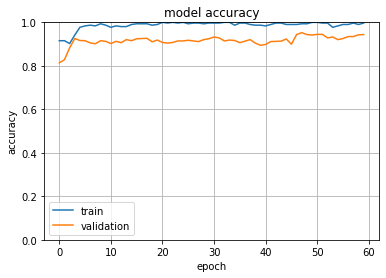

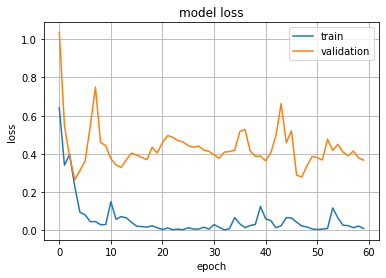

In [ ]:
# summarize history for accuracy
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim(0, 1)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid(True)
plt.legend(['train', 'validation'], loc='best') 
plt.savefig("model_accuracy_RN.png")
plt.show()

# summarize history for loss 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid(True)
plt.legend(['train', 'validation'], loc='upper right') 
plt.savefig("model_loss_RN.png")
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
from operator import truediv
import itertools

In [ ]:
def Accuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [ ]:
import seaborn as sns
def reports(y_pred, y_test):
   target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
           ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
            'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
           'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
           'Stone-Steel-Towers']
   classification = classification_report(y_test, y_pred)
   oa = accuracy_score(y_test, y_pred)
   confusion = confusion_matrix(y_test, y_pred)
   plt.figure(figsize = (16,16))
   sns.heatmap(confusion,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = target_names , yticklabels = target_names)
   each_acc, aa = Accuracy(confusion)
   kappa = cohen_kappa_score(y_test, y_pred)
   print( "classification result: \n")
   print(classification)
   
   return classification, confusion, np.array([oa, aa, kappa] + list(each_acc)) * 100


PARAMETERS 14850128
280/280 [==============================] - 4s 16ms/step
classification result: 

              precision    recall  f1-score   support

           0       1.00      0.34      0.51        41
           1       0.92      0.94      0.93      1246
           2       0.90      0.94      0.92       724
           3       0.93      1.00      0.96       207
           4       0.99      0.74      0.85       422
           5       0.94      0.94      0.94       637
           6       0.49      1.00      0.66        24
           7       1.00      1.00      1.00       418
           8       1.00      0.29      0.45        17
           9       0.93      0.96      0.94       849
          10       0.95      0.97      0.96      2143
          11       0.93      0.94      0.93       517
          12       0.88      0.91      0.90       179
          13       0.99      0.97      0.98      1104
          14       0.93      1.00      0.96       337
          15       1.00      0.70 

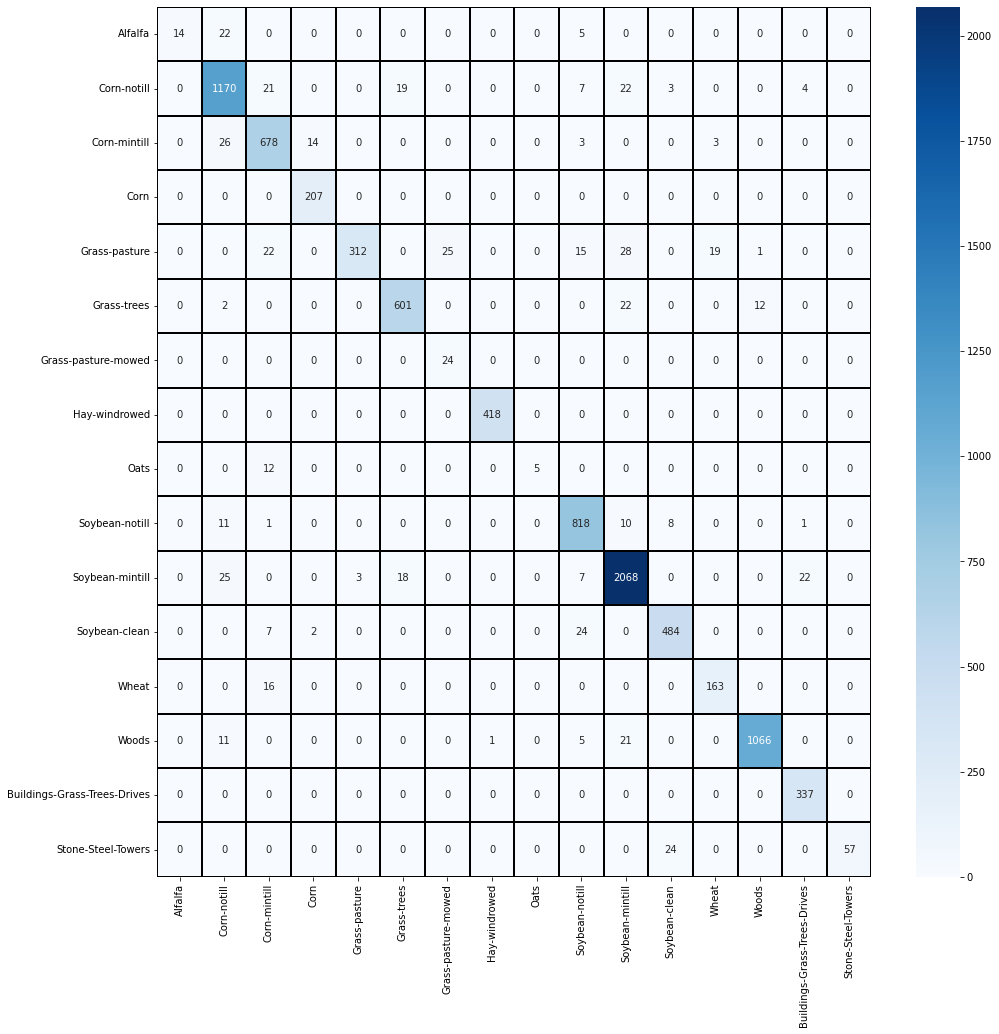

In [ ]:
print("PARAMETERS", model_resnet.count_params())
stats[pos,:] = reports(np.argmax(model_resnet.predict(x_test), axis=1), y_test)[2]
print(list(stats[-1]))

# LinkNet

---

In [ ]:
from keras.initializers import RandomNormal
from keras.models import Model
from tensorflow.keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Concatenate
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g

# define a decoder block
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g

# define the standalone generator model
def modifiedLinkNet(image_shape):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=image_shape)
    # encoder model
    e1 = define_encoder_block(in_image, 64, batchnorm=False)
    e2 = define_encoder_block(e1, 128)
    e3 = define_encoder_block(e2, 256)
    # bottleneck, no batch norm and relu
    b = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e3)
    b = Activation('relu')(b)
    # decoder model
    d3=decoder_block(b,e3,256)
    d2= decoder_block(d3, e2, 128,dropout=False)
    d1 = decoder_block(d2, e1, 64,dropout=False)
    # output
    g = Conv2DTranspose(3, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d1)
    out_image = Activation('tanh')(g)
    layer1 = Flatten()(out_image)
    layer1= Dense(128,activation="relu")(layer1)
    layer1 = Dropout(0.1,seed = 2019)(layer1)
    layer2= Dense(64,activation="relu")(layer1)
    layer2 = Dropout(0.1,seed = 2019)(layer2)
    layer3= Dense(32,activation="relu")(layer2)
    layer3 = Dropout(0.1,seed = 2019)(layer3)
    layer4= Dense(16,activation="softmax")(layer2)
    # define model
    model = Model(in_image, layer4)
    return model

In [ ]:
model_linknet = modifiedLinkNet(x_train[0].shape)
model_linknet.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_8 (Conv2D)              (None, 32, 32, 64)   3136        ['input_11[0][0]']               
                                                                                                  
 leaky_re_lu_6 (LeakyReLU)      (None, 32, 32, 64)   0           ['conv2d_8[0][0]']               
                                                                                                  
 conv2d_9 (Conv2D)              (None, 16, 16, 128)  131200      ['leaky_re_lu_6[0][0]']          
                                                                                           

In [ ]:
model_linknet.compile(loss=categorical_crossentropy, optimizer=Adam(lr=lrate), metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history=model_linknet.fit(x_train, keras_to_categorical(y_train, num_class),
                        batch_size=batch_size,
                        epochs=60,
                        verbose=verbosetrain,
                        validation_data=valdata,
                        callbacks = [ModelCheckpoint("best_model.h5", monitor='val_loss', verbose=0, save_best_only=True)])

Epoch 1/60
Epoch 2/60
Epoch 3/60
Epoch 4/60
Epoch 5/60
Epoch 6/60
Epoch 7/60
Epoch 8/60
Epoch 9/60
Epoch 10/60
Epoch 11/60
Epoch 12/60
Epoch 13/60
Epoch 14/60
Epoch 15/60
Epoch 16/60
Epoch 17/60
Epoch 18/60
Epoch 19/60
Epoch 20/60
Epoch 21/60
Epoch 22/60
Epoch 23/60
Epoch 24/60
Epoch 25/60
Epoch 26/60
Epoch 27/60
Epoch 28/60
Epoch 29/60
Epoch 30/60
Epoch 31/60
Epoch 32/60
Epoch 33/60
Epoch 34/60
Epoch 35/60
Epoch 36/60
Epoch 37/60
Epoch 38/60
Epoch 39/60
Epoch 40/60
Epoch 41/60
Epoch 42/60
Epoch 43/60
Epoch 44/60
Epoch 45/60
Epoch 46/60
Epoch 47/60
Epoch 48/60
Epoch 49/60
Epoch 50/60
Epoch 51/60
Epoch 52/60
Epoch 53/60
Epoch 54/60
Epoch 55/60
Epoch 56/60
Epoch 57/60
Epoch 58/60
Epoch 59/60
Epoch 60/60


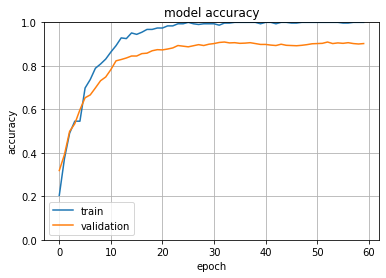

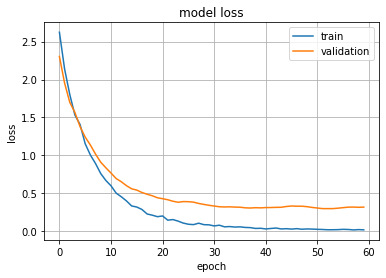

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim(0, 1)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid(True)
plt.legend(['train', 'validation'], loc='best') 
plt.savefig("model_accuracy_100.png")
plt.show()

# summarize history for loss 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid(True)
plt.legend(['train', 'validation'], loc='upper right') 
plt.savefig("model_loss_100.png")
plt.show()

PARAMETERS 5659219
280/280 [==============================] - 3s 9ms/step
classification result: 

              precision    recall  f1-score   support

           0       1.00      0.41      0.59        41
           1       0.94      0.95      0.95      1246
           2       0.92      0.92      0.92       724
           3       0.98      0.87      0.92       207
           4       0.98      0.80      0.88       422
           5       0.94      0.97      0.96       637
           6       0.57      1.00      0.73        24
           7       1.00      1.00      1.00       418
           8       1.00      0.35      0.52        17
           9       0.89      0.91      0.90       849
          10       0.96      0.89      0.92      2143
          11       0.90      0.87      0.89       517
          12       0.93      0.98      0.96       179
          13       0.97      0.97      0.97      1104
          14       0.55      0.96      0.70       337
          15       0.95      0.65   

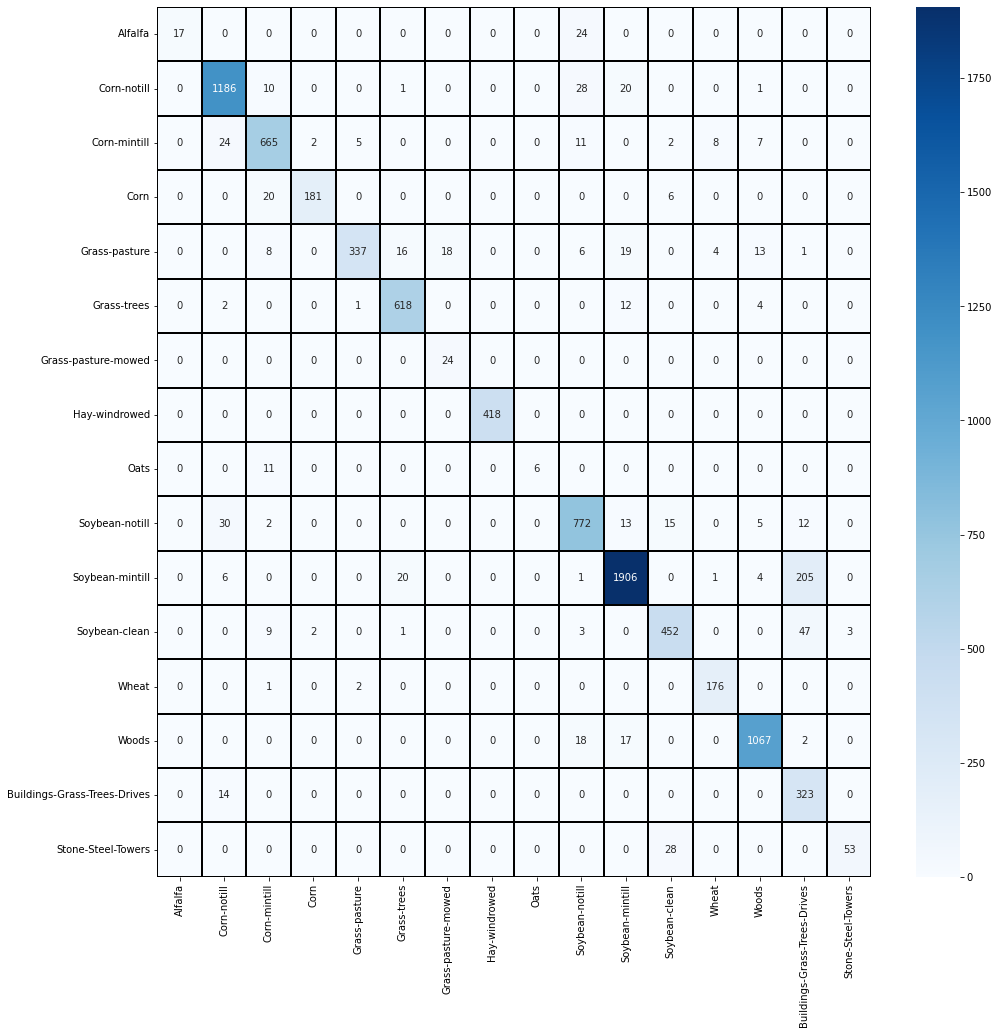

In [ ]:
print("PARAMETERS", model_linknet.count_params())
stats[pos,:] = reports(np.argmax(model_linknet.predict(x_test), axis=1), y_test)[2]
print(list(stats[-1]))